# Making a barabasi albert graph
the paper used this graph due to its preferential attachment to high degree nodes.

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import EoN
import random as rnd
rnd.seed()
import copy

In [3]:
def drawGz(G,z):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws G with node labels from partition z
    #
    # input  : G is a networkx graph
    #        : z is a dictionary of group labels for G's nodes
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    colors = ['blue','red','green','purple','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)
    
    node_colors = []
    for i in G.nodes():
        if z[i]=='S':
            cid = 0
        if z[i]=='I':
            cid = 1
        if z[i]=='R':
            cid = 2
        if z[i]=='Q':
            cid = 3
        node_colors.append(colors[int(cid)])
    nsize  = 600
    flabel = True

    if G.order() > 50:
        nsize  = 100
        flabel = False
    
    nx.draw_kamada_kawai(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it prettier
    #nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

def plot_CCDF(kis):
    # input : a list of degrees, e.g., from a networkx graph G
    # output: a plot of the CCDF of the degree distribution Pr(K>=k) for k>=1
    
    kmax = max(kis)

    # histogram and plot
    counts, bins = np.histogram(kis, bins=[i for i in range(kmax+2)], density=True)
    cumcounts = np.cumsum(counts)
    cumcounts = np.insert(cumcounts,0,0)
    plt.loglog(bins[1:-1], 1-cumcounts[1:-1], 'rs', alpha=0.5)
    plt.xlabel('Degree, k')
    plt.ylabel('Pr(K>=k)')
    plt.title('CCDF of Barabasi Albert Graph')
    plt.show()
    return

def plot_SIR(St, It, Rt, Qt, t, tracing_type):
    fig = plt.figure()
    ax1 = fig.add_subplot(111) # put multiple 
    plt.plot(range(t), St, 'bo-', alpha=0.5,label='S(t)')  # plot the log-likelihood trajectory
    plt.plot(range(t), It, 'rv-', alpha=0.5,label='I(t)')  # plot the log-likelihood trajectory
    plt.plot(range(t), Rt, 'gs-', alpha=0.5,label='R(t)')  # plot the log-likelihood trajectory
    plt.plot(range(t), Qt, 'ys-', alpha=0.5,label='Q(t)')  # plot the log-likelihood trajectory
    plt.ylabel('number of nodes')
    plt.xlabel('time, t')
    plt.legend(loc='upper right');
    plt.title(tracing_type)
    plt.show()

number of nodes, n  = 10000
number of edges, m  = 29991
mean degree, k = 5.9982
highest degree node, k_max = 308


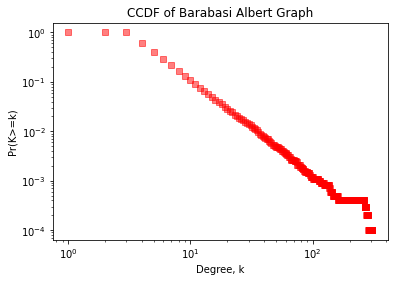

In [4]:
G = nx.barabasi_albert_graph(10000, 3)
n = G.number_of_nodes()
m = G.number_of_edges()
i = 0

kin_mean = i/n
o = 0
D = G.degree()
deg = []
i = 0
k_max = 0
for item in D:
    deg.append(item[1])
    i += item[1]
    if item[1] > k_max:
        k_max = item[1]
k_mean = i/n
ind = 0
##### do not modify below here #####
print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}')
print(f'mean degree, k = {k_mean}')
print(f'highest degree node, k_max = {k_max}')
plot_CCDF(deg)

In [5]:
def forwardTracing(G, q):
    #This function performs a normal SIR simulation, with the added function of quarantining
    #unifected neighbors (exposed) with probability q
    nodes = nx.nodes
    n = G.order()
    zt = dict.fromkeys(range(n), ['S', 'NQ']) #S, I, R, and NQ or Q for if the node is quarantined
    Sc,Ic,Rc,Qc = n,0,0,0 # S,I,R,Q node counts, initial
    for node in G.nodes(): #randomly infect approximately 1% of the population
        if rnd.random() < 0.01:
            zt[node] = ['I', 'NQ']
            Sc = Sc -1
            Ic = Ic +1
    t = 1
    beta = 0.3 # probability of {S-I} -> {I-I}
    gmma = 0.071 # probability of {I}   -> {R}
    quar = q # probability of identifying an infected individual, i used the estimated rate of detection from BMC
    St = [] # S(t), time series of number of S nodes per time step t
    It = [] # I(t), time series of number of I nodes per time step t
    Rt = [] # R(t), time series of number of R nodes per time step t
    Qt = [] # Q(t), time series of number of Q nodes per time step t
    Quar_Degrees = []
    St.append(Sc)
    It.append(Ic)
    Rt.append(Rc)
    Qt.append(Qc)
    while any(zt[node][0] == 'I' for node in G.nodes()):
        zu = copy.deepcopy(zt) # nodes states for next time step (synchronous updates)

        # do S -> I transitions
        for e in G.edges():
            i,j = e[0],e[1]           # this edge (i,j)
            if zt[i][0]=='I' and zt[j][0]=='S' and zu[j][0]!='I' and zt[j][1] == 'NQ' and zt[i][1] == 'NQ':
                if rnd.random() < beta:
                    zu[j] = ['I', zt[j][1]]       # i infects j for next round
                    Sc,Ic = Sc-1,Ic+1 # update counts

            if zt[i][0]=='S' and zt[j][0]=='I' and zu[i][0]!='I' and zt[i][1] == 'NQ' and zt[j][1] == 'NQ' :
                if rnd.random() < beta:
                    zu[i] = ['I', zt[i][1]]       # j infects i for next round
                    Sc,Ic = Sc-1,Ic+1 # update counts

        # do I -> R, Qi -> R, and Qs -> S transitions
        for i in G.nodes():
            recovered = False
            if zt[i][0] == 'I' and rnd.random() < gmma and zt[i][1] == 'NQ': #recovers, not quarantined
                zu[i] = ['R', 'NQ']           # i recovers (R)
                Ic,Rc = Ic-1,Rc+1     # update counts
                recovered = True
            if zt[i][0] == 'I' and rnd.random() < gmma and zt[i][1] == 'Q': #recovers, quarantined
                zu[i] = ['R', 'NQ']           # i recovers (R)
                Qc,Rc,Ic = Qc-1,Rc+1, Ic-1     # update counts
            if zt[i][1] == 'Q' and zt[i][0] == 'S' and rnd.random() < gmma: #uninfected nodes leaves quarantine
                zu[i] = ['S', 'NQ'] #because the node was quarantined but not infected, it returns to S instead of R
                Qc = Qc-1
            if zt[i][0] == 'I' and zt[i][1] == 'NQ' and rnd.random() < quar and not recovered: #if infected and detected and hasnt recovered this iteration
                zu[i] = ['I', 'Q']  #i is quarantined
                Quar_Degrees.append(G.degree[i])
                Qc =  Qc+1 #update counts
                neighbors = nx.neighbors(G, i) #we identify all neighbors
                for neighbor in neighbors:
                    if rnd.random() < 0.2: #for this estimate we will assume that 1/5 neighbors are traced
                        if zt[neighbor][0] == 'S' and zu[neighbor][0] != 'I' and zu[neighbor][1] == 'NQ': #quarantines uninfected neighbors
                            zu[neighbor] = ['S', 'Q']
                            Quar_Degrees.append(G.degree[neighbor])
                            Qc = Qc+1 
        
        
        #identify infection, quarantine infection, and conduct forward contact tracing to attempt to quarantine exposed neighbors
        
                
            
        # update all states synchronously, update clock
        zt = copy.deepcopy(zu)
        t  = t+1

        St.append(Sc)
        It.append(Ic)
        Rt.append(Rc) # append these counts to the time series
        Qt.append(Qc)
    return St, It, Rt, Qt, t, Quar_Degrees


Safe: 13, Infected: 0, Recovered 9987, Quarantined: 0
Mean Degree of Quarantined Nodes:  0


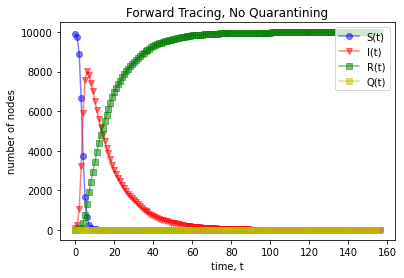

Safe: 399, Infected: 0, Recovered 9601, Quarantined: 0
Mean Degree of Quarantined Nodes:  5.991809494918853


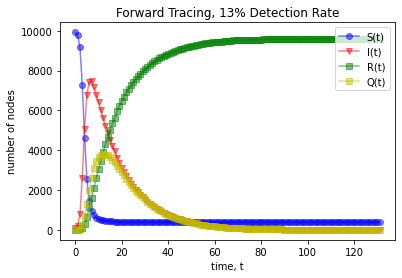

Safe: 1269, Infected: 0, Recovered 8731, Quarantined: 1
Mean Degree of Quarantined Nodes:  6.214240942710292


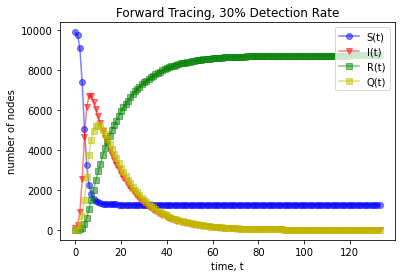

In [9]:
St, It, Rt, Qt, t, deg = forwardTracing(G, 0)
print(f'Safe: {St[-1]}, Infected: {It[-1]}, Recovered {Rt[-1]}, Quarantined: {Qt[-1]}')
print('Mean Degree of Quarantined Nodes: ', 0)
plot_SIR(St, It, Rt, Qt, t, 'Forward Tracing, No Quarantining')
St, It, Rt, Qt, t, deg = forwardTracing(G, .13) #detection rate for Covid 19
print(f'Safe: {St[-1]}, Infected: {It[-1]}, Recovered {Rt[-1]}, Quarantined: {Qt[-1]}')
print('Mean Degree of Quarantined Nodes: ', np.mean(deg))
plot_SIR(St, It, Rt, Qt, t, 'Forward Tracing, 13% Detection Rate')
St, It, Rt, Qt, t, deg = forwardTracing(G, .3)
print(f'Safe: {St[-1]}, Infected: {It[-1]}, Recovered {Rt[-1]}, Quarantined: {Qt[-1]}')
print('Mean Degree of Quarantined Nodes: ', np.mean(deg))
plot_SIR(St, It, Rt, Qt, t, 'Forward Tracing, 30% Detection Rate')



In [6]:
def forward_backwardTracing(G, q):
    #This function performs a normal SIR simulation, with the added function of quarantining
    #unifected and infected neighbors with probability q
    nodes = nx.nodes
    n = G.order()
    zt = dict.fromkeys(range(n), ['S', 'NQ']) #S, I, R, and NQ or Q for if the node is quarantined
    Sc,Ic,Rc,Qc = n,0,0,0 # S,I,R,Q node counts, initial
    for node in G.nodes(): #randomly infect approximately 1% of the population
        if rnd.random() < 0.01:
            zt[node] = ['I', 'NQ']
            Sc = Sc -1
            Ic = Ic +1
    t = 1
    beta = 0.3 # probability of {S-I} -> {I-I}
    gmma = 0.071 # probability of {I}   -> {R}
    quar = q # probability of identifying an infected individual, i used the estimated rate of detection from BMC
    St = [] # S(t), time series of number of S nodes per time step t
    It = [] # I(t), time series of number of I nodes per time step t
    Rt = [] # R(t), time series of number of R nodes per time step t
    Qt = [] # Q(t), time series of number of Q nodes per time step t
    St.append(Sc)
    It.append(Ic)
    Rt.append(Rc)
    Qt.append(Qc)
    Quar_Degrees = []
    while any(zt[node][0] == 'I' for node in G.nodes()):
        zu = copy.deepcopy(zt) # nodes states for next time step (synchronous updates)

        # do S -> I transitions
        for e in G.edges():
            i,j = e[0],e[1]           # this edge (i,j)
            if zt[i][0]=='I' and zt[j][0]=='S' and zu[j][0]!='I' and zt[j][1] == 'NQ' and zt[i][1] == 'NQ':
                if rnd.random() < beta:
                    zu[j] = ['I', zt[j][1]]       # i infects j for next round
                    Sc,Ic = Sc-1,Ic+1 # update counts

            if zt[i][0]=='S' and zt[j][0]=='I' and zu[i][0]!='I' and zt[i][1] == 'NQ' and zt[j][1] == 'NQ' :
                if rnd.random() < beta:
                    zu[i] = ['I', zt[i][1]]       # j infects i for next round
                    Sc,Ic = Sc-1,Ic+1 # update counts

        # do I -> R, Qi -> R, and Qs -> S transitions
        for i in G.nodes():
            recovered = False
            if zt[i][0] == 'I' and rnd.random() < gmma and zt[i][1] == 'NQ': #recovers, not quarantined
                zu[i] = ['R', 'NQ']           # i recovers (R)
                Ic,Rc = Ic-1,Rc+1     # update counts
                recovered = True
            if zt[i][0] == 'I' and rnd.random() < gmma and zt[i][1] == 'Q': #recovers, quarantined
                zu[i] = ['R', 'NQ']           # i recovers (R)
                Qc,Rc,Ic = Qc-1,Rc+1, Ic-1     # update counts
            if zt[i][1] == 'Q' and zt[i][0] == 'S' and rnd.random() < gmma: #uninfected nodes leaves quarantine
                zu[i] = ['S', 'NQ'] #because the node was quarantined but not infected, it returns to S instead of R
                Qc = Qc-1
            if zt[i][0] == 'I' and zt[i][1] == 'NQ' and rnd.random() < quar and not recovered: #if infected and detected and hasnt recovered this iteration
                zu[i] = ['I', 'Q']  #i is quarantined
                Qc =  Qc+1 #update counts
                Quar_Degrees.append(G.degree[i])
                neighbors = nx.neighbors(G, i) #we identify all neighbors
                for neighbor in neighbors:
                    if rnd.random() < 0.2: #for this estimate we will assume that 1/5 neighbors are traced
                        if zt[neighbor][1] == 'NQ' and zu[neighbor][1] == 'NQ': #quarantines uninfected neighbors
                            zu[neighbor] = [zu[neighbor][0], 'Q']
                            Quar_Degrees.append(G.degree[neighbor])
                            Qc = Qc+1
        
        
        #identify infection, quarantine infection, and conduct forward contact tracing to attempt to quarantine exposed neighbors
        
                
            
        # update all states synchronously, update clock
        zt = copy.deepcopy(zu)
        t  = t+1

        St.append(Sc)
        It.append(Ic)
        Rt.append(Rc) # append these counts to the time series
        Qt.append(Qc)
    return St, It, Rt, Qt, t, Quar_Degrees


Safe: 14, Infected: 0, Recovered 9986, Quarantined: 0
Mean Degree of Quarantined Nodes:  nan


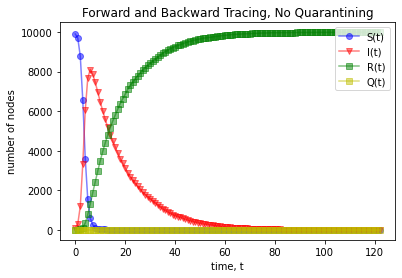

Safe: 745, Infected: 0, Recovered 9255, Quarantined: 990
Mean Degree of Quarantined Nodes:  7.073882293508461


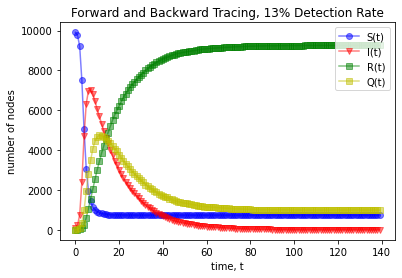

Safe: 1923, Infected: 0, Recovered 8077, Quarantined: 833
Mean Degree of Quarantined Nodes:  6.9472884525479195


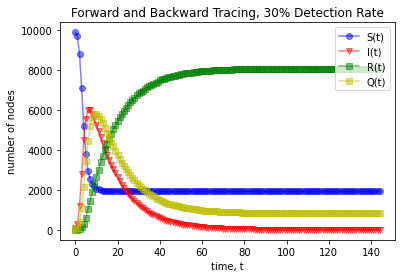

In [20]:
St, It, Rt, Qt, t, deg = forward_backwardTracing(G, 0)
print(f'Safe: {St[-1]}, Infected: {It[-1]}, Recovered {Rt[-1]}, Quarantined: {Qt[-1]}')
print('Mean Degree of Quarantined Nodes: ', np.mean(deg))
plot_SIR(St, It, Rt, Qt, t, 'Forward and Backward Tracing, No Quarantining')
St, It, Rt, Qt, t, deg = forward_backwardTracing(G, .13) #detection rate for Covid 19
print(f'Safe: {St[-1]}, Infected: {It[-1]}, Recovered {Rt[-1]}, Quarantined: {Qt[-1]}')
print('Mean Degree of Quarantined Nodes: ', np.mean(deg))
plot_SIR(St, It, Rt, Qt, t, 'Forward and Backward Tracing, 13% Detection Rate')
St, It, Rt, Qt, t, deg = forward_backwardTracing(G, .3)
print(f'Safe: {St[-1]}, Infected: {It[-1]}, Recovered {Rt[-1]}, Quarantined: {Qt[-1]}')
print('Mean Degree of Quarantined Nodes: ', np.mean(deg))
plot_SIR(St, It, Rt, Qt, t, 'Forward and Backward Tracing, 30% Detection Rate')

In [7]:
def backwardTracing(G, q):
    #This function performs a normal SIR simulation, with the added function of quarantining
    #unifected and infected neighbors with probability q
    nodes = nx.nodes
    n = G.order()
    zt = dict.fromkeys(range(n), ['S', 'NQ']) #S, I, R, and NQ or Q for if the node is quarantined
    Sc,Ic,Rc,Qc = n,0,0,0 # S,I,R,Q node counts, initial
    for node in G.nodes(): #randomly infect approximately 1% of the population
        if rnd.random() < 0.01:
            zt[node] = ['I', 'NQ']
            Sc = Sc -1
            Ic = Ic +1
    t = 1
    beta = 0.3 # probability of {S-I} -> {I-I}
    gmma = 0.071 # probability of {I}   -> {R}
    quar = q # probability of identifying an infected individual, i used the estimated rate of detection from BMC
    St = [] # S(t), time series of number of S nodes per time step t
    It = [] # I(t), time series of number of I nodes per time step t
    Rt = [] # R(t), time series of number of R nodes per time step t
    Qt = [] # Q(t), time series of number of Q nodes per time step t
    St.append(Sc)
    It.append(Ic)
    Rt.append(Rc)
    Qt.append(Qc)
    Quar_Degrees = []
    while any(zt[node][0] == 'I' for node in G.nodes()):
        zu = copy.deepcopy(zt) # nodes states for next time step (synchronous updates)

        # do S -> I transitions
        for e in G.edges():
            i,j = e[0],e[1]           # this edge (i,j)
            if zt[i][0]=='I' and zt[j][0]=='S' and zu[j][0]!='I' and zt[j][1] == 'NQ' and zt[i][1] == 'NQ':
                if rnd.random() < beta:
                    zu[j] = ['I', zt[j][1]]       # i infects j for next round
                    Sc,Ic = Sc-1,Ic+1 # update counts

            if zt[i][0]=='S' and zt[j][0]=='I' and zu[i][0]!='I' and zt[i][1] == 'NQ' and zt[j][1] == 'NQ' :
                if rnd.random() < beta:
                    zu[i] = ['I', zt[i][1]]       # j infects i for next round
                    Sc,Ic = Sc-1,Ic+1 # update counts

        # do I -> R, Qi -> R, and Qs -> S transitions
        for i in G.nodes():
            recovered = False
            if zt[i][0] == 'I' and rnd.random() < gmma and zt[i][1] == 'NQ': #recovers, not quarantined
                zu[i] = ['R', 'NQ']           # i recovers (R)
                Ic,Rc = Ic-1,Rc+1     # update counts
                recovered = True
            if zt[i][0] == 'I' and rnd.random() < gmma and zt[i][1] == 'Q': #recovers, quarantined
                zu[i] = ['R', 'NQ']           # i recovers (R)
                Qc,Rc,Ic = Qc-1,Rc+1, Ic-1     # update counts
            if zt[i][1] == 'Q' and zt[i][0] == 'S' and rnd.random() < gmma: #uninfected nodes leaves quarantine
                zu[i] = ['S', 'NQ'] #because the node was quarantined but not infected, it returns to S instead of R
                Qc = Qc-1
            if zt[i][0] == 'I' and zt[i][1] == 'NQ' and rnd.random() < quar and not recovered: #if infected and detected and hasnt recovered this iteration
                zu[i] = ['I', 'Q']  #i is quarantined
                Quar_Degrees.append(G.degree[i])
                Qc =  Qc+1 #update counts
                neighbors = nx.neighbors(G, i) #we identify all neighbors
                for neighbor in neighbors:
                    if rnd.random() < 0.2: #for this estimate we will assume that 1/5 neighbors are traced
                        if zu[neighbor][0] == 'I' and zu[neighbor][1] == 'NQ': #quarantines infected neighbors
                            #we only use the next rounds data because if we used this rounds data nodes would get counted more than
                            #once, also, we have no want to quarantine recently recovered nodes
                            zu[neighbor] = ['I', 'Q']
                            Quar_Degrees.append(G.degree[neighbor])
                            Qc = Qc+1
        
        
        #identify infection, quarantine infection, and conduct forward contact tracing to attempt to quarantine exposed neighbors
        
                
            
        # update all states synchronously, update clock
        zt = copy.deepcopy(zu)
        t  = t+1

        St.append(Sc)
        It.append(Ic)
        Rt.append(Rc) # append these counts to the time series
        Qt.append(Qc)
    return St, It, Rt, Qt, t, Quar_Degrees


Safe: 11, Infected: 0, Recovered 9989, Quarantined: 0
Mean Degree of Quarantined Nodes:  nan


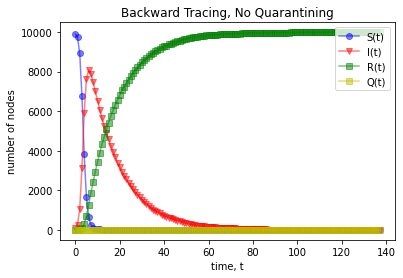

Safe: 424, Infected: 0, Recovered 9576, Quarantined: 170
Mean Degree of Quarantined Nodes:  6.437800787516407


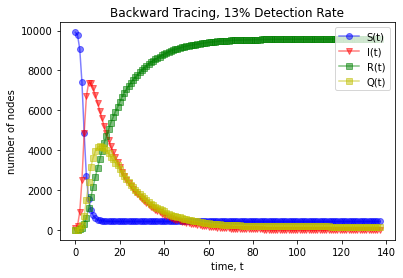

Safe: 1368, Infected: 0, Recovered 8632, Quarantined: 259
Mean Degree of Quarantined Nodes:  6.538329820864067


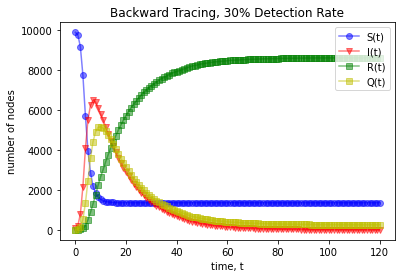

In [22]:
 St, It, Rt, Qt, t, deg = backwardTracing(G, 0)
print(f'Safe: {St[-1]}, Infected: {It[-1]}, Recovered {Rt[-1]}, Quarantined: {Qt[-1]}')
print('Mean Degree of Quarantined Nodes: ', np.mean(deg))
plot_SIR(St, It, Rt, Qt, t, 'Backward Tracing, No Quarantining')
St, It, Rt, Qt, t, deg = backwardTracing(G, .13) #detection rate for Covid 19
print(f'Safe: {St[-1]}, Infected: {It[-1]}, Recovered {Rt[-1]}, Quarantined: {Qt[-1]}')
print('Mean Degree of Quarantined Nodes: ', np.mean(deg))
plot_SIR(St, It, Rt, Qt, t, 'Backward Tracing, 13% Detection Rate')
St, It, Rt, Qt, t, deg = backwardTracing(G, .3)
print(f'Safe: {St[-1]}, Infected: {It[-1]}, Recovered {Rt[-1]}, Quarantined: {Qt[-1]}')
print('Mean Degree of Quarantined Nodes: ', np.mean(deg))
plot_SIR(St, It, Rt, Qt, t, 'Backward Tracing, 30% Detection Rate')

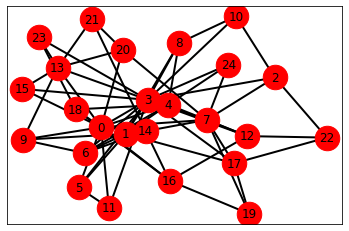

In [150]:
G = nx.barabasi_albert_graph(25, 3)
nx.draw_networkx(G,arrows=True,with_labels=True,node_size=600,node_color='r',width=2)

In [8]:
StavgF = []
for i in range(10):
    St, It, Rt, Qt, t, deg = forwardTracing(G, 0.13)
    StavgF.append(St[-1])
print(f'Average Number of Susceptible at the End of Forward Tracing (10 rounds): {np.mean(StavgF)}')
StavgFB = []
for i in range(10):
    St, It, Rt, Qt, t, deg = forward_backwardTracing(G, 0.13)
    StavgFB.append(St[-1])
print(f'Average Number of Susceptible at the End of Forward/Backward Tracing (10 rounds): {np.mean(StavgFB)}')
StavgB = []
for i in range(10):
    St, It, Rt, Qt, t, deg = backwardTracing(G, 0.13)
    StavgB.append(St[-1])
print(f'Average Number of Susceptible at the End of Backward Tracing (10 rounds): {np.mean(StavgB)}')

Average Number of Susceptible at the End of Forward Tracing (10 rounds): 394.9
Average Number of Susceptible at the End of Forward/Backward Tracing (10 rounds): 710.7
Average Number of Susceptible at the End of Backward Tracing (10 rounds): 466.5
